# **Task 4: Optimize Portfolio Based on Forecast**

In [22]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

In [25]:
def optimize_portfolio_task4(price_df,
                             tsla_expected_annual_return,
                             n_portfolios=50000,
                             trading_days=252,
                             rf=0.0,
                             seed=42):
    """
    Optimize portfolio with 3 assets: TSLA (forecast return), BND & SPY (historical returns).
    
    Args:
        price_df (pd.DataFrame): Historical daily prices with columns ['TSLA', 'BND', 'SPY'].
        tsla_expected_annual_return (float): Expected annual return for TSLA from forecast.
        n_portfolios (int): Number of random portfolios to simulate.
        trading_days (int): Number of trading days per year (default 252).
        rf (float): Risk-free rate (default 0.0).
        seed (int): Random seed for reproducibility.
        
    Returns:
        dict: Summary of recommended portfolio with weights, return, volatility, Sharpe ratio.
    """
    try:
        # Basic validation
        required_cols = ['TSLA', 'BND', 'SPY']
        if not all(col in price_df.columns for col in required_cols):
            raise ValueError(f"price_df must contain columns: {required_cols}")
        
        # Compute historical annualized returns for BND & SPY
        def annualized_return(series):
            returns = series.pct_change().dropna()
            mean_daily = returns.mean()
            return (1 + mean_daily)**trading_days - 1
        
        bnd_return = annualized_return(price_df['BND'])
        spy_return = annualized_return(price_df['SPY'])
        
        # Compose expected returns vector
        expected_returns = np.array([tsla_expected_annual_return, bnd_return, spy_return])
        asset_names = ['TSLA', 'BND', 'SPY']
        
        # Compute annualized covariance matrix of returns
        returns_df = price_df.pct_change().dropna()
        cov_annual = returns_df.cov() * trading_days
        
        # Monte Carlo simulation of random portfolios
        np.random.seed(seed)
        n_assets = len(asset_names)
        results = np.zeros((n_portfolios, 3 + n_assets))  # columns: return, vol, sharpe, weights...
        
        for i in range(n_portfolios):
            weights = np.random.random(n_assets)
            weights /= np.sum(weights)
            port_return = np.dot(weights, expected_returns)
            port_vol = np.sqrt(weights.T @ cov_annual.values @ weights)
            sharpe = (port_return - rf) / port_vol if port_vol != 0 else 0.0
            
            results[i, 0] = port_return
            results[i, 1] = port_vol
            results[i, 2] = sharpe
            results[i, 3:] = weights
        
        cols = ['Return', 'Volatility', 'Sharpe'] + [f'Weight_{a}' for a in asset_names]
        sim_df = pd.DataFrame(results, columns=cols)
        
        # Identify max Sharpe and min Volatility portfolios
        max_sharpe_idx = sim_df['Sharpe'].idxmax()
        min_vol_idx = sim_df['Volatility'].idxmin()
        max_sharpe_port = sim_df.loc[max_sharpe_idx]
        min_vol_port = sim_df.loc[min_vol_idx]
        
        # Plot Efficient Frontier
        plt.figure(figsize=(10,7))
        sc = plt.scatter(sim_df['Volatility'], sim_df['Return'], c=sim_df['Sharpe'], cmap='viridis', alpha=0.4)
        plt.colorbar(sc, label='Sharpe Ratio')
        plt.scatter(max_sharpe_port['Volatility'], max_sharpe_port['Return'], marker='*', color='r', s=250, label='Max Sharpe')
        plt.scatter(min_vol_port['Volatility'], min_vol_port['Return'], marker='o', color='b', s=150, label='Min Volatility')
        plt.xlabel('Annualized Volatility')
        plt.ylabel('Annualized Return')
        plt.title('Efficient Frontier - for Assets (Portfolios)')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Recommend max Sharpe portfolio by default
        recommended = max_sharpe_port
        
        weights_dict = {asset_names[i]: round(recommended[f'Weight_{asset_names[i]}'], 4) for i in range(n_assets)}
        
        summary = {
            'choice': 'Max Sharpe Ratio (Tangency) Portfolio',
            'weights': weights_dict,
            'expected_annual_return': round(recommended['Return'], 6),
            'annual_volatility': round(recommended['Volatility'], 6),
            'sharpe_ratio': round(recommended['Sharpe'], 6)
        }
        
        display("Recommended Portfolio Summary:")
        display(summary)
        
        return summary
    
    except Exception as e:
        print(f"Error during portfolio optimization: {e}")
        return None

[*********************100%***********************]  3 of 3 completed


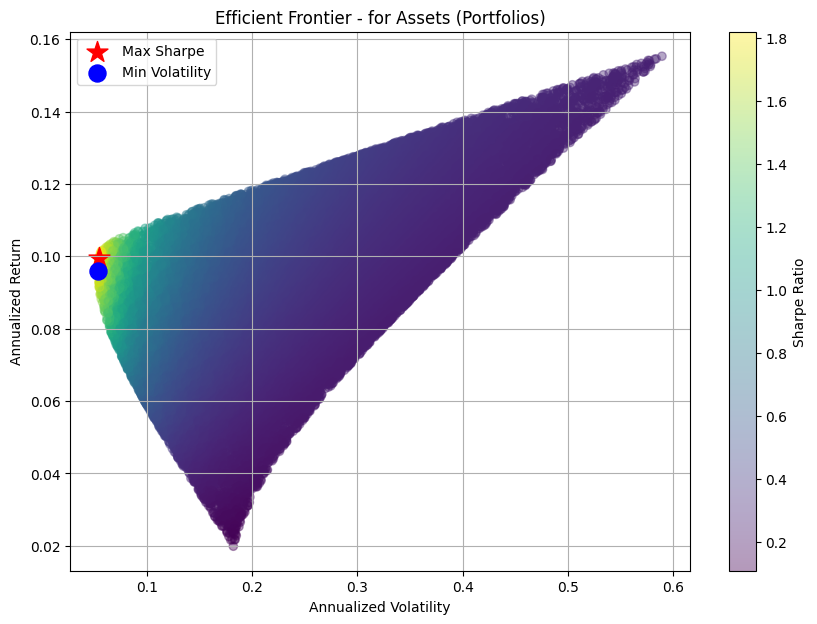

'Recommended Portfolio Summary:'

{'choice': 'Max Sharpe Ratio (Tangency) Portfolio',
 'weights': {'TSLA': np.float64(0.9948),
  'BND': np.float64(0.0048),
  'SPY': np.float64(0.0004)},
 'expected_annual_return': np.float64(0.099632),
 'annual_volatility': np.float64(0.054756),
 'sharpe_ratio': np.float64(1.819566)}

In [26]:
# Download historical prices
price_df = yf.download(['TSLA', 'BND', 'SPY'], start='2015-07-01', end='2025-07-31')['Close']

# Our forecasted Tesla annual return (from our model)
tsla_forecast_return = 0.1  # our actual forecast

# Now call the portfolio optimizer
result = optimize_portfolio_task4(price_df, tsla_forecast_return)